In [16]:
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
import pandas as pd

BASE_DIR = Path("/Users/thunthita/Lidarforiypnb/LIDar/RawFile")

DAYS = [
    "05-01-2026",
    "06-01-2026",
    "07-01-2026",
    "08-01-2026",
    "09-01-2026",
    "12-01-2026",
]

rows = []   # ← list of DataFrames (to be concatenated)

def process_minimpl(MiniMPL: pd.DataFrame) -> pd.DataFrame:
    nrb_max = MiniMPL["copol_nrb"].max()
    norm = MiniMPL["copol_nrb"] / nrb_max if nrb_max not in (0, None) else 0

    return pd.DataFrame({
        "range_raw": MiniMPL["range_raw"],
        "range_m_for_NRB": MiniMPL["range_raw"] * 1000,
        "range_m": MiniMPL["range_nrb"] * 1000,
        "copol_raw": MiniMPL["copol_raw"],
        "copol_snr": MiniMPL["copol_snr"],
        "copol_nrb": MiniMPL["copol_nrb"],
        "pbls": MiniMPL["pbls"],
        "Normalize_copol_nrb": norm,
    })


for day in DAYS:
    day_folder = BASE_DIR / f"{day}-DATfile"
    if not day_folder.exists():
        print(f"❌ Folder missing: {day_folder}")
        continue

    date_obj = pd.to_datetime(day, format="%d-%m-%Y")
    date_str = date_obj.strftime("%Y%m%d")

    times = pd.date_range(
        start=f"{date_str} 00:00",
        end=f"{date_str} 23:55",
        freq="5min"
    )

    print(f"\n📂 Processing {day_folder}")

    for t in times:
        ts_str = t.strftime("%Y%m%d%H%M")
        infile = day_folder / f"MPL_5038_{ts_str}.csv"

        if not infile.exists():
            continue

        MiniMPL = pd.read_csv(infile)
        df = process_minimpl(MiniMPL)

        # 🔑 ADD REQUIRED FIRST COLUMNS
        df.insert(0, "timestamp", t)
        df.insert(0, "day", day)

        rows.append(df)

MiniMPL_ALL = pd.concat(rows, ignore_index=True)



📂 Processing /Users/thunthita/Lidarforiypnb/LIDar/RawFile/05-01-2026-DATfile

📂 Processing /Users/thunthita/Lidarforiypnb/LIDar/RawFile/06-01-2026-DATfile

📂 Processing /Users/thunthita/Lidarforiypnb/LIDar/RawFile/07-01-2026-DATfile

📂 Processing /Users/thunthita/Lidarforiypnb/LIDar/RawFile/08-01-2026-DATfile

📂 Processing /Users/thunthita/Lidarforiypnb/LIDar/RawFile/09-01-2026-DATfile

📂 Processing /Users/thunthita/Lidarforiypnb/LIDar/RawFile/12-01-2026-DATfile


In [18]:
MiniMPL_ALL

,day,timestamp,range_raw,range_m_for_NRB,range_m,copol_raw,copol_snr,copol_nrb,pbls,Normalize_copol_nrb
0,05-01-2026,2026-01-05 00:00:00,0.029979,29.979246,119.91698,22.973406,74635.140000,0.217418,2.428319,0.919494
1,05-01-2026,2026-01-05 00:00:00,0.059958,59.958490,149.89623,9.440220,30666.166000,0.235153,NaN,0.994498
2,05-01-2026,2026-01-05 00:00:00,0.089938,89.937740,179.87548,8.520437,27675.664000,0.236075,NaN,0.998398
3,05-01-2026,2026-01-05 00:00:00,0.119917,119.916980,209.85472,8.234554,26750.950000,0.213818,NaN,0.904269
4,05-01-2026,2026-01-05 00:00:00,0.149896,149.896230,239.83397,8.518830,27674.977000,0.192532,NaN,0.814248
...,...,...,...,...,...,...,...,...,...,...
287995,05-01-2026,2026-01-05 23:55:00,29.859330,29859.330000,NaN,0.000773,0.181044,NaN,NaN,NaN
287996,05-01-2026,2026-01-05 23:55:00,29.889309,29889.309000,NaN,0.000803,0.381869,NaN,NaN,NaN
287997,05-01-2026,2026-01-05 23:55:00,29.919287,29919.287000,NaN,0.000684,-0.012051,NaN,NaN,NaN
287998,05-01-2026,2026-01-05 23:55:00,29.949266,29949.266000,NaN,0.000759,0.227460,NaN,NaN,NaN


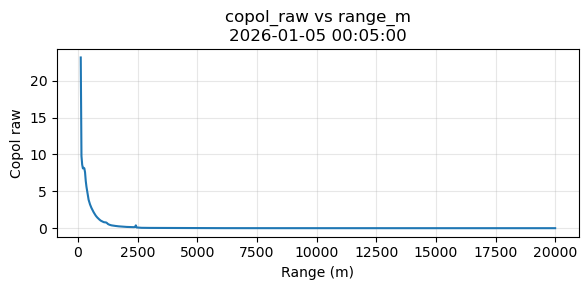

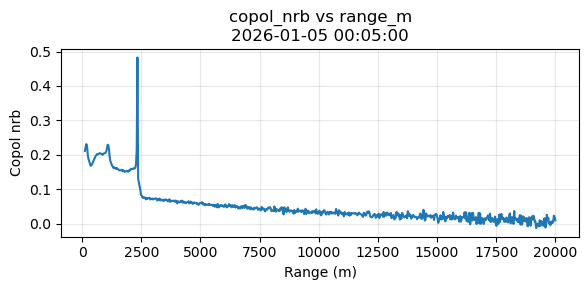

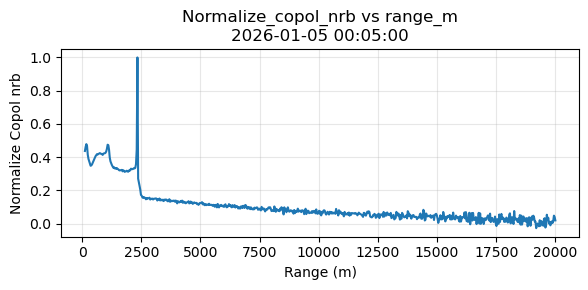

In [20]:
def plot_profile_at_timestamp(
    df: pd.DataFrame,
    ts,
    *,
    xcol: str,
    ycol: str,
    figsize=(6, 3),
    xlabel=None,
    ylabel=None,
    title=None,
    xscale="linear",
    yscale="linear",
    xlim=None,
    ylim=None,
    show=True
):
    """
    Plot ycol vs xcol for a single timestamp.

    Parameters
    ----------
    df : pd.DataFrame
        Long-format DataFrame (must contain 'timestamp')
    ts : str or pd.Timestamp
        Timestamp to plot
    xcol, ycol : str
        Column names for x and y axes
    """

    ts = pd.Timestamp(ts)
    df_t = df[df["timestamp"] == ts]

    if df_t.empty:
        raise ValueError(f"No data found for timestamp {ts}")

    if xcol not in df_t.columns or ycol not in df_t.columns:
        raise KeyError(f"Columns '{xcol}' or '{ycol}' not found")

    plt.figure(figsize=figsize)
    plt.plot(df_t[xcol], df_t[ycol])

    plt.xlabel(xlabel if xlabel else xcol)
    plt.ylabel(ylabel if ylabel else ycol)

    if title:
        plt.title(title)
    else:
        plt.title(f"{ycol} vs {xcol}\n{ts}")

    plt.grid(True, alpha=0.3)
    plt.xscale(xscale)
    plt.yscale(yscale)

    if xlim:
        plt.xlim(*xlim)
    if ylim:
        plt.ylim(*ylim)

    plt.tight_layout()

    if show:
        plt.show()

plot_profile_at_timestamp(
    MiniMPL_ALL,
    "2026-01-05 00:05",
    xcol="range_m",
    ycol="copol_raw",
    xlabel="Range (m)",
    ylabel="Copol raw"
)

plot_profile_at_timestamp(
    MiniMPL_ALL,
    "2026-01-05 00:05",
    xcol="range_m",
    ycol="copol_nrb",
    xlabel="Range (m)",
    ylabel="Copol nrb"
)
plot_profile_at_timestamp(
    MiniMPL_ALL,
    "2026-01-05 00:05",
    xcol="range_m",
    ycol="Normalize_copol_nrb",
    xlabel="Range (m)",
    ylabel="Normalize Copol nrb"
)


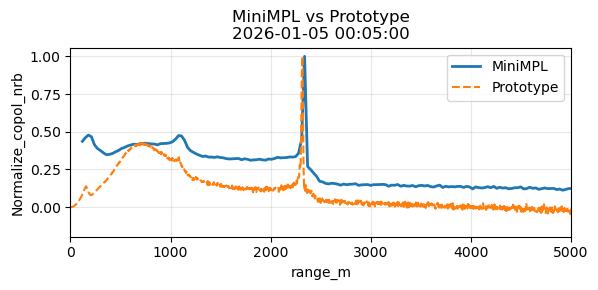

In [22]:
def plot_minimpl_vs_csv(
    MiniMPL_ALL: pd.DataFrame,
    *,
    ts,
    csv_path,
    xcol_minimpl,
    ycol_minimpl,
    xcol_csv,
    ycol_csv,
    label_minimpl="MiniMPL",
    label_csv="Prototype",
    figsize=(6, 3),
    xscale="linear",
    yscale="linear",
    xlim=None,
    ylim=None,
    title=None,
    show=True
):
    """
    Compare MiniMPL profile with external CSV profile at one timestamp.
    """

    ts = pd.Timestamp(ts)
    csv_path = Path(csv_path)

    if not csv_path.exists():
        raise FileNotFoundError(csv_path)

    # ---- MiniMPL ----
    df_m = MiniMPL_ALL[MiniMPL_ALL["timestamp"] == ts]
    if df_m.empty:
        raise ValueError(f"No MiniMPL data for timestamp {ts}")

    # ---- External CSV ----
    df_c = pd.read_csv(csv_path)

    if xcol_csv not in df_c.columns or ycol_csv not in df_c.columns:
        raise KeyError("CSV columns not found")

    # ---- Plot ----
    plt.figure(figsize=figsize)

    plt.plot(
        df_m[xcol_minimpl],
        df_m[ycol_minimpl],
        label=label_minimpl,
        linewidth=2
    )

    plt.plot(
        df_c[xcol_csv],
        df_c[ycol_csv],
        label=label_csv,
        linestyle="--"
    )

    plt.xlabel(xcol_minimpl)
    plt.ylabel(ycol_minimpl)
    plt.grid(True, alpha=0.3)
    plt.legend()

    plt.xscale(xscale)
    plt.yscale(yscale)

    if xlim:
        plt.xlim(*xlim)
    if ylim:
        plt.ylim(*ylim)

    if title:
        plt.title(title)
    else:
        plt.title(f"{label_minimpl} vs {label_csv}\n{ts}")

    plt.tight_layout()

    if show:
        plt.show()

plot_minimpl_vs_csv(
    MiniMPL_ALL,
    ts="2026-01-05 00:05",
    csv_path="/Users/thunthita/Lidarforiypnb/LIDar/Pict/05-01-2026-0005/05-01-2026-0005_processed.csv",
    xcol_minimpl="range_m",
    ycol_minimpl="Normalize_copol_nrb",
    xcol_csv="range_m",
    ycol_csv="range2_norm",
    label_minimpl="MiniMPL",
    label_csv="Prototype",
    yscale="linear",
    xlim=(0, 5000)
)


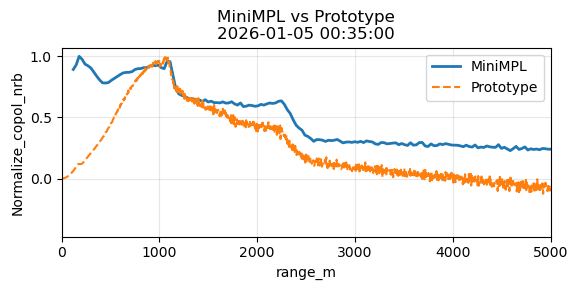

In [26]:
plot_minimpl_vs_csv(
    MiniMPL_ALL,
    ts="2026-01-05 00:35",
    csv_path="/Users/thunthita/Lidarforiypnb/LIDar/Pict/05-01-2026-0035/05-01-2026-0035_processed.csv",
    xcol_minimpl="range_m",
    ycol_minimpl="Normalize_copol_nrb",
    xcol_csv="range_m",
    ycol_csv="range2_norm",
    label_minimpl="MiniMPL",
    label_csv="Prototype",
    yscale="linear",
    xlim=(0, 5000)
)

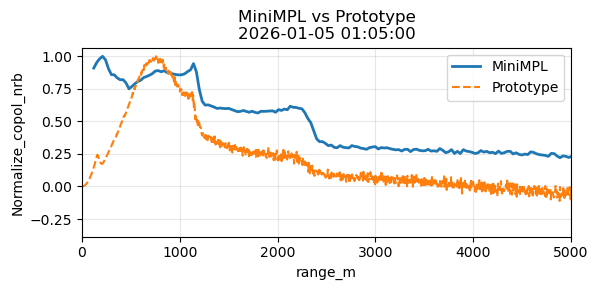

In [28]:
plot_minimpl_vs_csv(
    MiniMPL_ALL,
    ts="2026-01-05 01:05",
    csv_path="/Users/thunthita/Lidarforiypnb/LIDar/Pict/05-01-2026-0105/05-01-2026-0105_processed.csv",
    xcol_minimpl="range_m",
    ycol_minimpl="Normalize_copol_nrb",
    xcol_csv="range_m",
    ycol_csv="range2_norm",
    label_minimpl="MiniMPL",
    label_csv="Prototype",
    yscale="linear",
    xlim=(0, 5000)
)

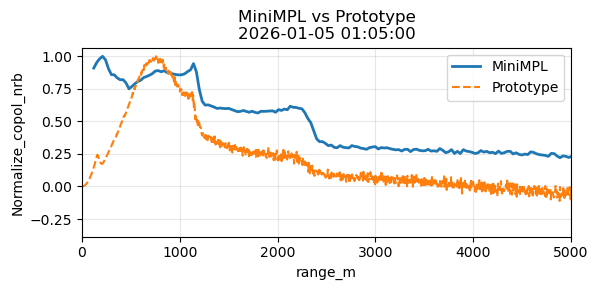

In [30]:
def make_minimpl_prototype_plotter(
    MiniMPL_ALL,
    *,
    day,
    ts,
    base_proto_dir
):
    ts = pd.Timestamp(ts)
    ts_str = ts.strftime("%H%M")

    csv_path = (
        Path(base_proto_dir)
        / f"{day}-{ts_str}"
        / f"{day}-{ts_str}_processed.csv"
    )

    def plot(**kwargs):
        return plot_minimpl_vs_csv(
            MiniMPL_ALL,
            ts=ts,
            csv_path=csv_path,
            **kwargs
        )

    return plot


plot_0105 = make_minimpl_prototype_plotter(
    MiniMPL_ALL,
    day="05-01-2026",
    ts="2026-01-05 01:05",
    base_proto_dir="/Users/thunthita/Lidarforiypnb/LIDar/Pict"
)

plot_0105(
    xcol_minimpl="range_m",
    ycol_minimpl="Normalize_copol_nrb",
    xcol_csv="range_m",
    ycol_csv="range2_norm",
    label_minimpl="MiniMPL",
    label_csv="Prototype",
    xlim=(0, 5000)
)


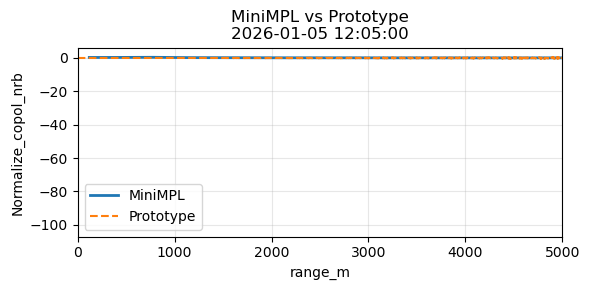

In [32]:
plot_1205 = make_minimpl_prototype_plotter(
    MiniMPL_ALL,
    day="05-01-2026",
    ts="2026-01-05 12:05",
    base_proto_dir="/Users/thunthita/Lidarforiypnb/LIDar/Pict"
)

plot_1205(
    xcol_minimpl="range_m",
    ycol_minimpl="Normalize_copol_nrb",
    xcol_csv="range_m",
    ycol_csv="range2_norm",
    label_minimpl="MiniMPL",
    label_csv="Prototype",
    xlim=(0, 5000)
)


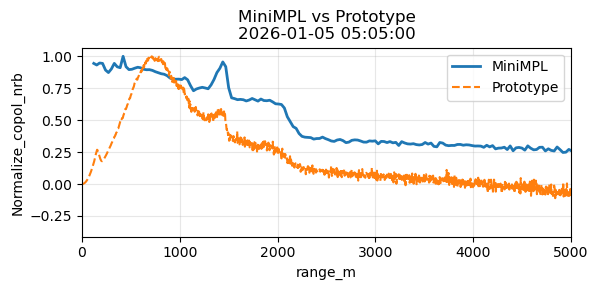

In [34]:
plot_0505 = make_minimpl_prototype_plotter(
    MiniMPL_ALL,
    day="05-01-2026",
    ts="2026-01-05 05:05",
    base_proto_dir="/Users/thunthita/Lidarforiypnb/LIDar/Pict"
)

plot_0505(
    xcol_minimpl="range_m",
    ycol_minimpl="Normalize_copol_nrb",
    xcol_csv="range_m",
    ycol_csv="range2_norm",
    label_minimpl="MiniMPL",
    label_csv="Prototype",
    xlim=(0, 5000)
)


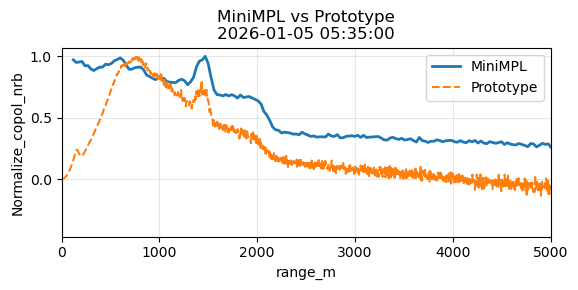

In [36]:
plot_0505 = make_minimpl_prototype_plotter(
    MiniMPL_ALL,
    day="05-01-2026",
    ts="2026-01-05 05:35",
    base_proto_dir="/Users/thunthita/Lidarforiypnb/LIDar/Pict"
)

plot_0505(
    xcol_minimpl="range_m",
    ycol_minimpl="Normalize_copol_nrb",
    xcol_csv="range_m",
    ycol_csv="range2_norm",
    label_minimpl="MiniMPL",
    label_csv="Prototype",
    xlim=(0, 5000)
)
